In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2

from glob import glob
import matplotlib.pyplot as plt

In [2]:
calibration_images = [image_path for image_path in sorted(glob("../data/calibration/*.jpg")) if np.array_equal(cv2.imread(image_path).shape[:2],  np.array([720, 1280]))]


{'bl': array([538.43945, 575.4545 ], dtype=float32),
 'br': array([922.8272, 549.9281], dtype=float32),
 'tl': array([545.3228 , 343.05032], dtype=float32),
 'tr': array([972.56885, 336.60718], dtype=float32)}


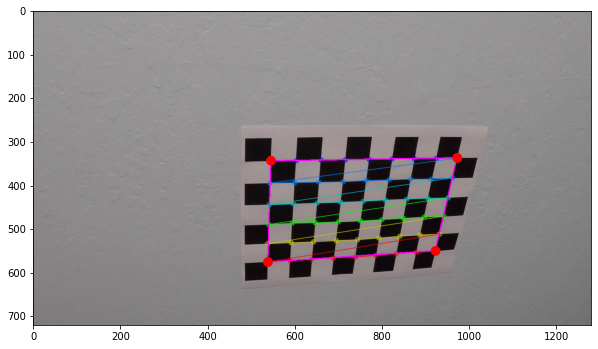

In [4]:
# Testing extreme rectangle extraction on the chessboard (for warping test)

from loris.calibration.utils import detect_corners, extreme_rect
from loris.perspective import rect_dict2nparray
from loris.utils import draw_polygone, highlight_corners
from pprint import pprint


nx = 9
ny = 6
sample_image = cv2.imread(calibration_images[1])
corners, shape = detect_corners(sample_image, nx=nx, ny=ny)
rect = extreme_rect(corners, 9)
pprint(rect)
plt.figure(figsize = (10, 10))
ax = plt.subplot(1, 1, 1)
ax.imshow(cv2.drawChessboardCorners(sample_image, (nx, ny), corners, True))
ax.imshow(draw_polygone(rect_dict2nparray(rect), sample_image))
highlight_corners(ax, rect)

In [5]:
# Sanity check (image shape)
for test_image in calibration_images:
    # print(f"{test_image} -> {cv2.imread(test_image).shape}")
    if not np.array_equal(cv2.imread(test_image).shape[:2],  [720, 1280]):
        print(f"{test_image}")

## Calibrate and undistort image

In [6]:
from loris.calibration.utils import calibrate, undistort
calibration_output = calibrate(calibration_images)

In [7]:
calibration_output['mtx']

array([[1.15996008e+03, 0.00000000e+00, 6.71800566e+02],
       [0.00000000e+00, 1.15500283e+03, 3.85820235e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

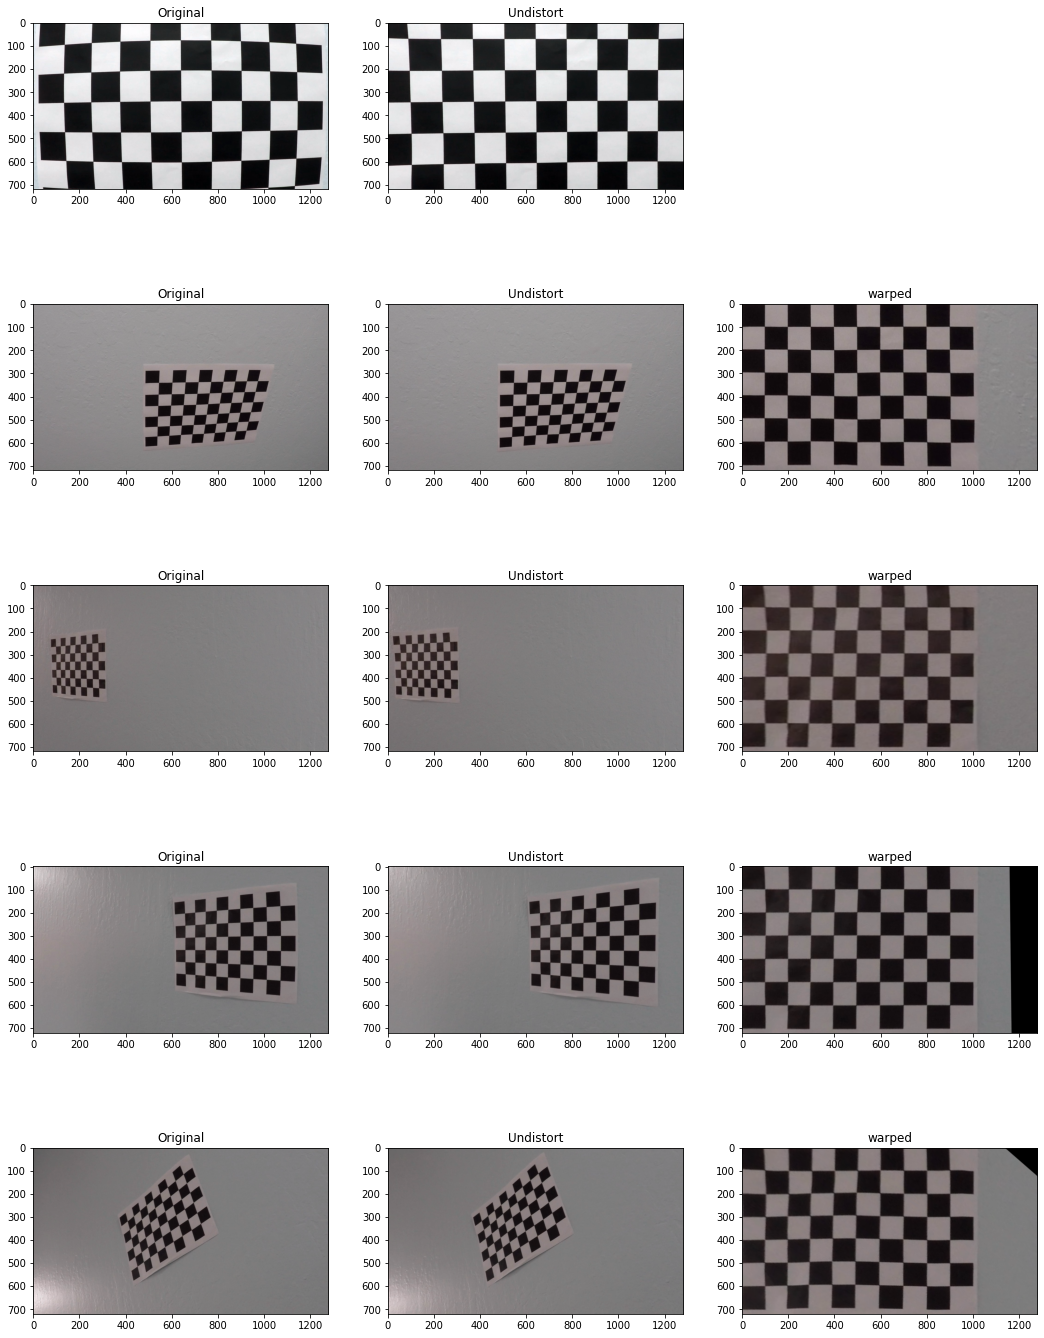

In [8]:
from loris.perspective import Warper

images_sample = calibration_images[:5]
plt.figure(figsize=(18, 5*len(images_sample)))
index = 1
for test_image in  map(cv2.imread, images_sample):
    orig_ax = plt.subplot(len(images_sample), 3, index)
    orig_ax.imshow(test_image)
    orig_ax.set_title("Original")
    status, output = undistort(test_image, calibration_output)
    if status:
        undistort_ax = plt.subplot(len(images_sample), 3, index+1)
        undistort_ax.imshow(output)
        undistort_ax.set_title("Undistort")

        # warp chessboard (maximal-inner) rectangle
        # use warper instead !!!
        corners, shape = detect_corners(output, nx=9, ny=6)
        
        if corners is not None:
            warped_ax = plt.subplot(len(images_sample), 3, index+2)

            chessboard_src = rect_dict2nparray(extreme_rect(corners, 9))
            chessboard_dest = np.float32([[100, 100], [900, 100], [900, 600], [100, 600]]) # each cell side == 100px 
            M = cv2.getPerspectiveTransform(chessboard_src, chessboard_dest)
            warped = cv2.warpPerspective(output, M, test_image.shape[:2][::-1], flags=cv2.INTER_LINEAR)
            warped_ax.imshow(warped)
            warped_ax.set_title("warped")
    index += 3

# Advanced lane detection

## Road section extraction and warping

In [9]:
straight_lines_images = list(glob("../data/lane_detection/test_images/straight*.jpg"))
print(straight_lines_images)

['../data/lane_detection/test_images/straight_lines1.jpg', '../data/lane_detection/test_images/straight_lines2.jpg']


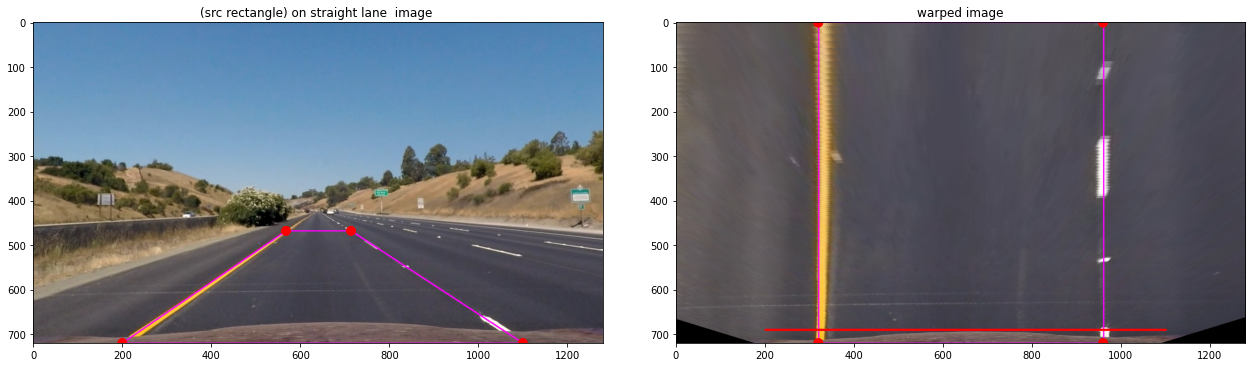

In [34]:
# Road/lane section for warping

from loris.perspective import PixelSize, Warper, rect_dict2nparray
from loris.utils import draw_polygone, draw_line

src = {"tl": [568, 468], "tr": [714, 468], "bl": [200, 720], "br": [1100, 720]}
dest = {"tl": [320, 0], "tr": [960, 0], "bl": [320, 720], "br": [960, 720]}

YM_PER_PIX = 26 / 690  #  Checked section length on google maps 4 + (2*(2 * 5.5)) a dash + 2 sep. (in the warped space)
XM_PER_PIX = 3.7 / (960-320)  # meters per pixel in x dimension (in the warped space)

pixel_size = PixelSize(y_pp=YM_PER_PIX, x_pp=XM_PER_PIX)

# Visualization/Sanity check
sample_image = cv2.imread(straight_lines_images[0])
warper = Warper(rect_dict2nparray(src), rect_dict2nparray(dest))

status, output = undistort(sample_image, calibration_output)

plt.figure(figsize=(18, 5))

if status:
    ax = plt.subplot(1, 2, 1)
    ax.set_title("(src rectangle) on straight lane  image ")
    warped = warper.warp(output)
    warped_ax = plt.subplot(1, 2, 2)
    warped_ax.set_title("warped image")
    ax.imshow(draw_polygone(rect_dict2nparray(src), cv2.cvtColor(output, cv2.COLOR_BGR2RGB)))
    highlight_corners(ax, src)
    # The horizontal red line delimits the measured section that to check its length in pixels (without loosing the region close to the car)
    warped_ax.imshow(draw_line(draw_polygone(rect_dict2nparray(dest), cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)),
        np.array([200, 690]), np.array([1100, 690]), thickness=4))
    highlight_corners(warped_ax, dest)
plt.tight_layout()

plt.savefig("../output_images/perspective_transform.jpg")


In [11]:
center = np.array([sample_image.shape[1]/2, sample_image.shape[0]-1, 1])
print(center)
result = np.matmul(warper._transform, center)
result/result[2]

[640. 719.   1.]


array([632.89065058, 719.53496191,   1.        ])

In [12]:
warper.inv_transform(warper.transform(src["tl"])) - src["tl"]

array([-4.54747351e-13, -5.68434189e-14])

## Thresholding (visualization)


In [13]:
# test_images = sorted(glob("../data/lane_detection/test_images/test*"))
test_images = sorted(glob("../data/videos/frame_*"))



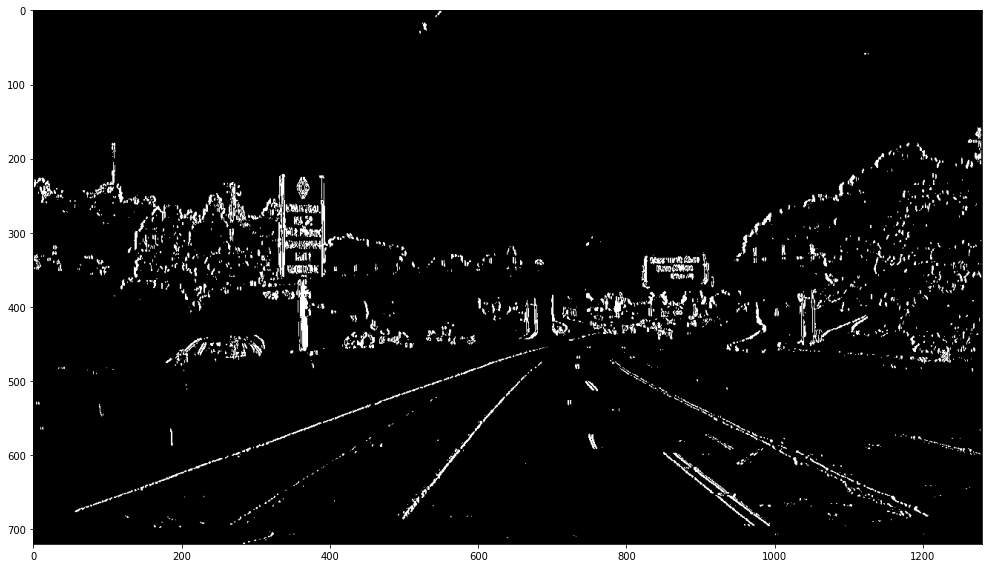

In [14]:
from loris.lane_detection.utils import grayscale, canny, gaussian_blur
from loris.lane_detection.threshold import  abs_sobel_thresh, mag_thresh, dir_threshold


sample_image = cv2.imread(test_images[2])
plt.figure(figsize=(16, 8))

sobel_x = cv2.Sobel(grayscale(sample_image), cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobel_x)
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

plt.imshow(sxbinary, cmap="gray")
plt.tight_layout()

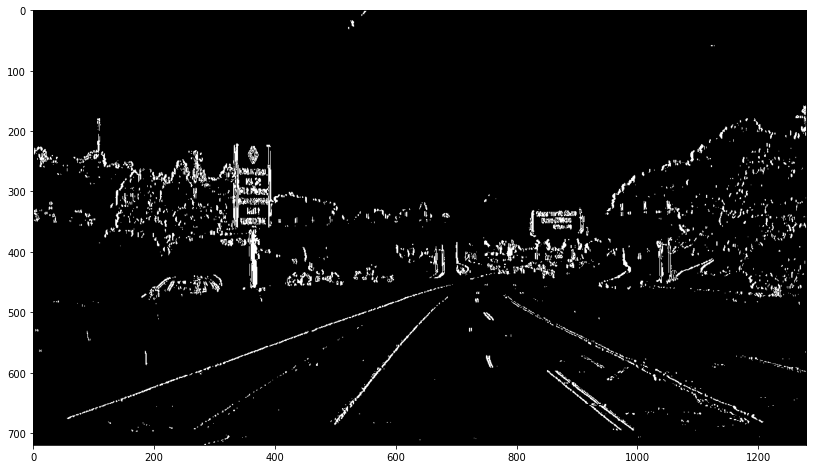

In [15]:
plt.figure(figsize=(16, 8))
plt.imshow(abs_sobel_thresh(sample_image, thresh=(20,100)), cmap="gray")

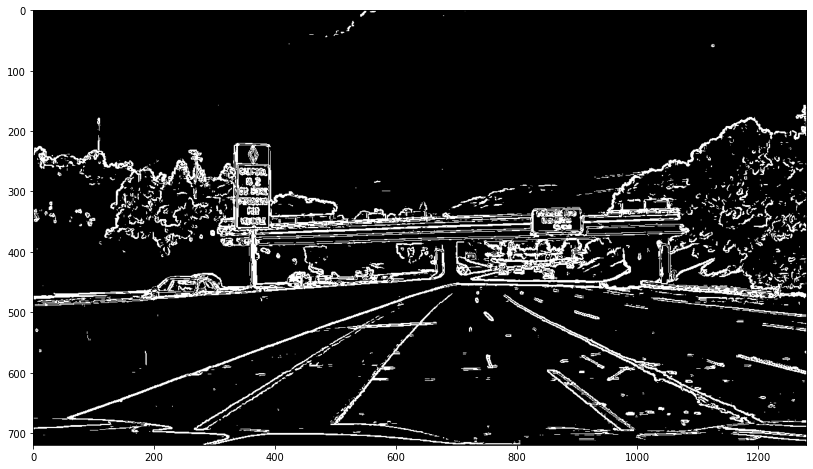

In [16]:
plt.figure(figsize=(16, 8))
plt.imshow(mag_thresh(sample_image, mag_thresh=(20, 100)), cmap="gray")

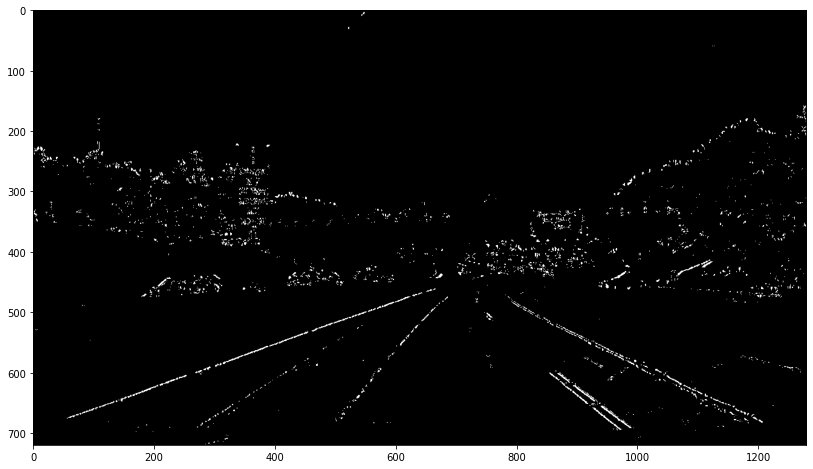

In [17]:
plt.figure(figsize=(16, 8))
plt.imshow(abs_sobel_thresh(sample_image, thresh=(20,100))*dir_threshold(sample_image, sobel_kernel=15, thresh=(.7, 1.3)), cmap="gray")

## Threshold pipeline testing

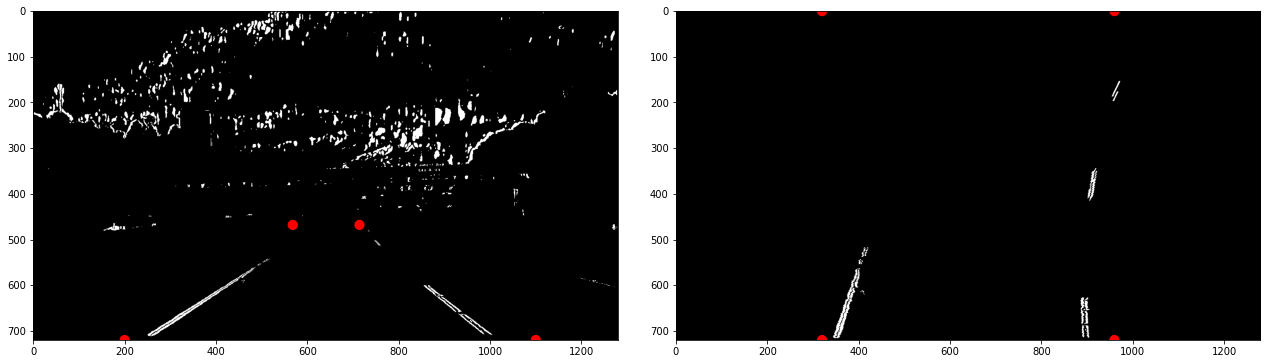

In [18]:
from loris.lane_detection.threshold import threshold_pipeline, combined_threshold


warper = Warper(rect_dict2nparray(src), rect_dict2nparray(dest))
status, output = undistort(sample_image, calibration_output)

if (status):
    thresholding_output = threshold_pipeline(output) 
    plt.figure(figsize=(18, 5))
    ax = plt.subplot(1, 2, 1)
    warped = warper.warp(thresholding_output)
    warped_ax = plt.subplot(1, 2, 2)
    ax.imshow(thresholding_output, cmap="gray") # warper.inv_warp(warped)
    highlight_corners(ax, src)
    warped_ax.imshow(warped, cmap="gray")
    highlight_corners(warped_ax, dest)
    plt.tight_layout()

plt.savefig("../output_images/perspective_transform_on_thresholded.jpg")

In [19]:
import matplotlib.pyplot as plt

def hist(img):
    bottom_half = img[img.shape[0]//2:]
    return np.sum(bottom_half, axis=0)

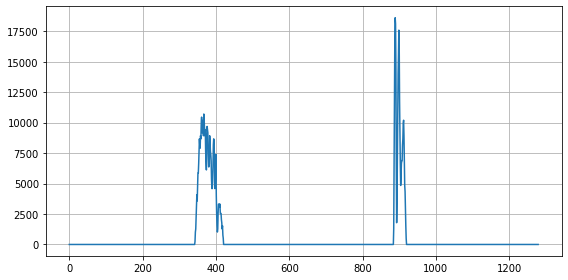

In [20]:
# Create histogram of image binary activations
histogram = hist(warped)
plt.figure(figsize=(8, 4))
plt.plot(histogram)
plt.grid()
plt.tight_layout()

plt.savefig("../output_images/perspective_transform_white_pixels_hitogram.jpg")

In [21]:
warped.shape

(720, 1280)

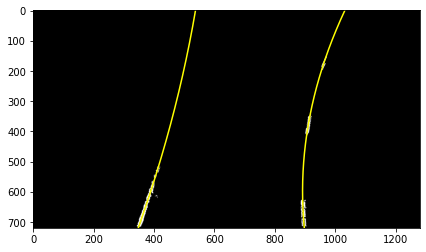

In [22]:
from loris.lane_detection.advanced import search_around_poly, non_zero, poly_fit, visualize, find_lane_pixels, apply_poly

# test lane initialization (find_lane_pixels)
leftx , lefty, rightx, righty = find_lane_pixels(warped)

left_fitx = poly_fit(lefty, leftx)
right_fitx = poly_fit(righty, rightx)

nonzerox, nonzeroy = non_zero(warped)
leftx, lefty, _ = search_around_poly(nonzerox, nonzeroy, left_fitx, margin=100)
rightx, righty, _ = search_around_poly(nonzerox, nonzeroy, right_fitx, margin=100)

plt.figure(figsize=(8, 4))

visualize(warped, left_fitx, right_fitx)

plt.savefig("../output_images/initalized_lines_ploynomes.jpg")


## Threshold output testing

In [23]:
for image_path in test_images:
    print(image_path)

../data/videos/frame_0.jpg
../data/videos/frame_1.jpg
../data/videos/frame_2.jpg
../data/videos/frame_3.jpg
../data/videos/frame_4.jpg
../data/videos/frame_5.jpg
../data/videos/frame_6.jpg
../data/videos/frame_7.jpg
../data/videos/frame_8.jpg
../data/videos/frame_9.jpg


<Figure size 1296x720 with 0 Axes>

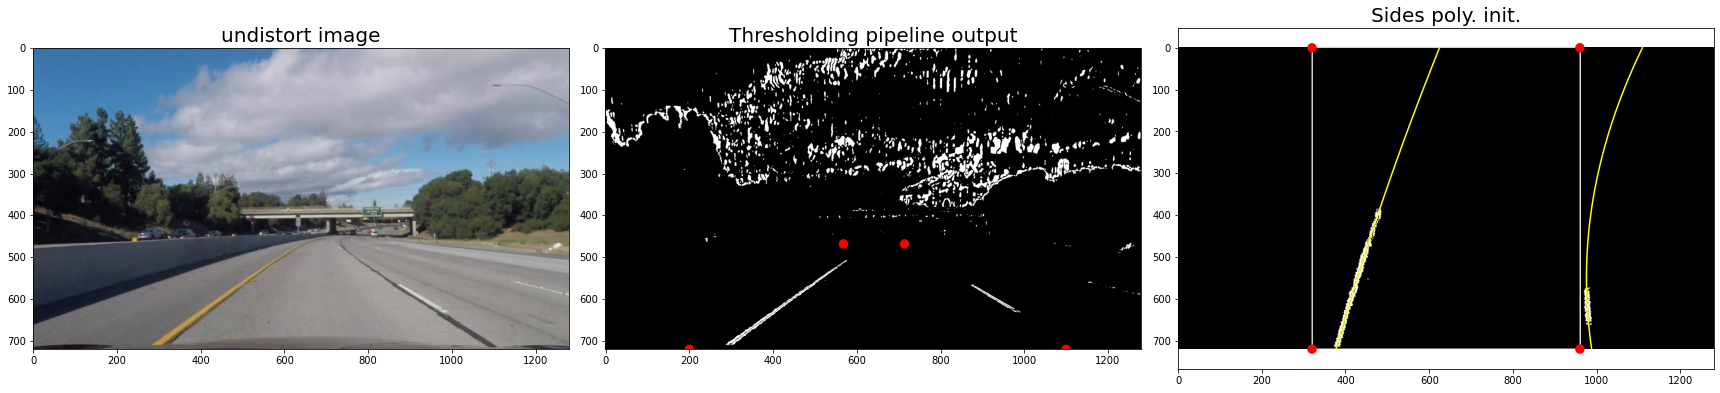

In [24]:
# Initialization 

sample_image = cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB)
hls = cv2.cvtColor(sample_image, cv2.COLOR_RGB2HLS)
result =  threshold_pipeline(sample_image)

warper = Warper(rect_dict2nparray(src), rect_dict2nparray(dest))
status, undistort_image = undistort(sample_image, calibration_output)
# test lane initialization (find_lane_pixels)

if status:
    plt.figure(figsize=(18, 10))
    thresholding_output =  threshold_pipeline(undistort_image)
    warped = warper.warp(thresholding_output)
    leftx , lefty, rightx, righty = find_lane_pixels(warped)

    left_poly = poly_fit(lefty, leftx)
    right_poly = poly_fit(righty, rightx)

    # Visualize initilization steps
    f, (original_ax, ax2, initialization_ax) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    original_ax.imshow(undistort_image, cmap="gray") # np.mean(hls[:, :, 1:], axis=-1)
    original_ax.set_title('undistort image', fontsize=20)

    ax2.imshow(thresholding_output, cmap="gray")
    ax2.set_title('Thresholding pipeline output', fontsize=20)
    highlight_corners(ax2, src)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    visualize(draw_polygone(rect_dict2nparray(dest), warped), left_poly,  right_poly, ax=initialization_ax)
    initialization_ax.set_title("Sides poly. init.", fontsize=20)
    highlight_corners(initialization_ax, dest)

plt.tight_layout()
plt.savefig("../output_images/initalized_lines_ploynomes_frame_0.jpg")



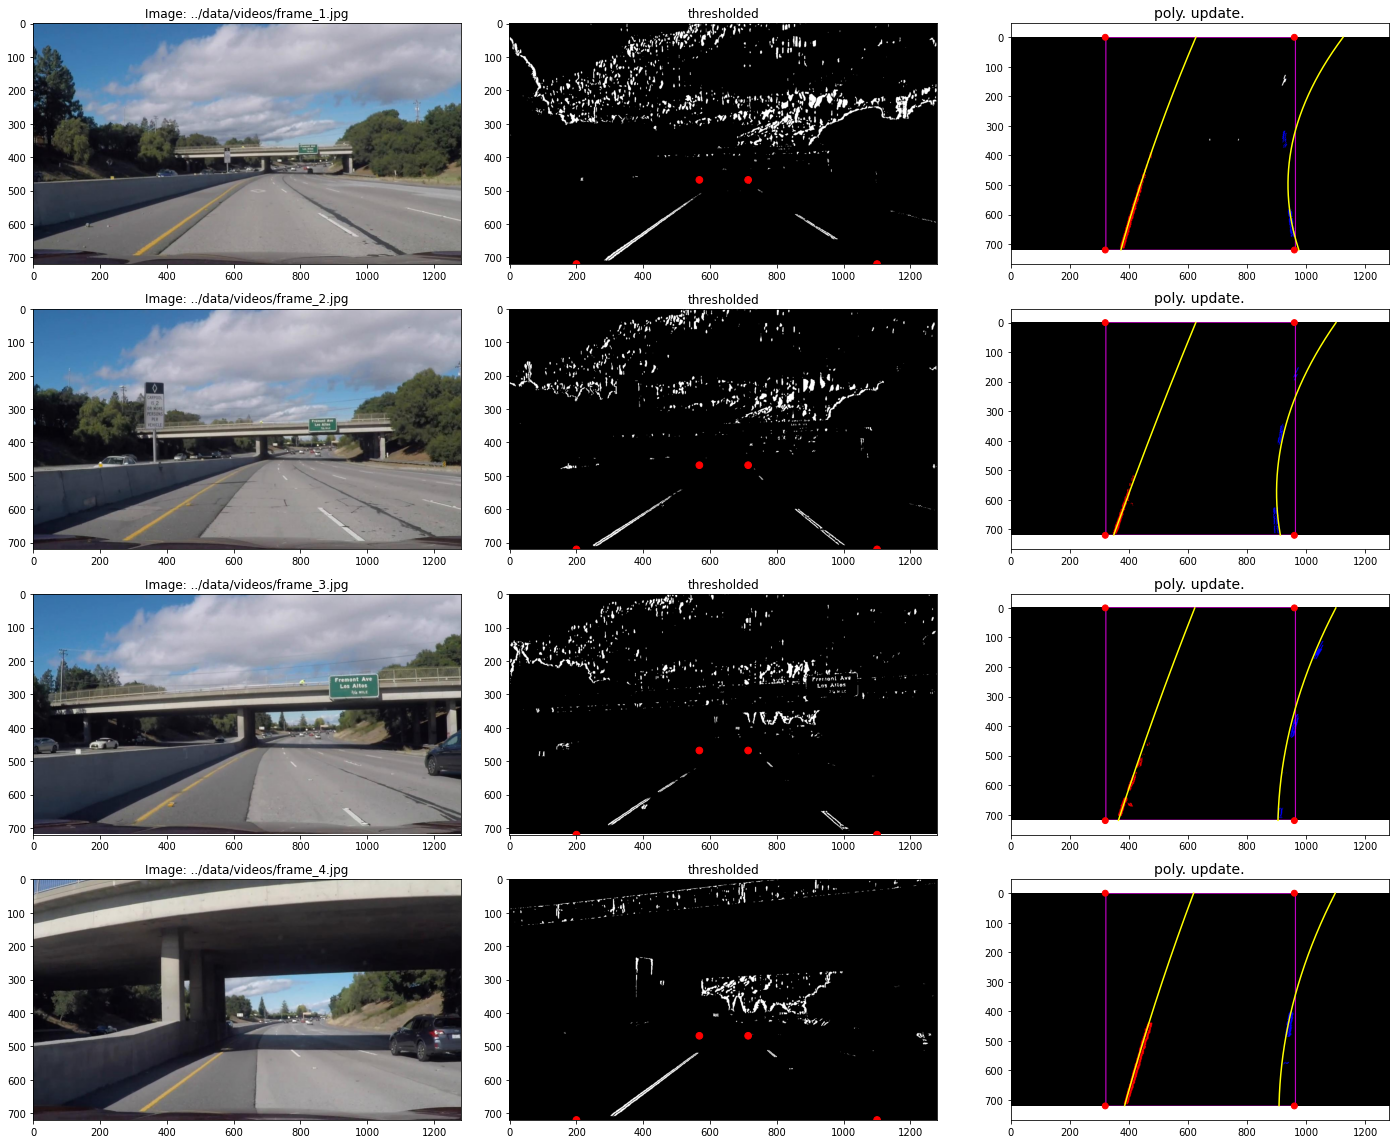

In [25]:
# Updating (principle)

selected_frames = test_images[1:5:]
rows = len(selected_frames)
plt.figure(figsize=(20, rows*4))
columns = 3
margin = 120

index = 1
for image_path in selected_frames:
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    status, output = undistort(image, calibration_output)
    if status:
        
        thresholding_output = threshold_pipeline(output)
        thresholded_warped = warper.warp(thresholding_output)

        # Search around previous 2n order (left/right) polynomes

        nonzerox, nonzeroy = non_zero(thresholded_warped)
        leftx, lefty, _ = search_around_poly(nonzerox, nonzeroy, left_poly, margin=margin)
        rightx, righty, _ = search_around_poly(nonzerox, nonzeroy, right_poly, margin=margin)


       
        # update with previous fitted line as a prior
        y_range = np.arange(warped.shape[0])


        # update left side 
        left_poly = poly_fit(
                    np.concatenate((lefty, y_range)),
                    np.concatenate((leftx, apply_poly(left_poly, y_range))),
                )        
        # update right side
        right_poly = poly_fit(
                    np.concatenate((righty, y_range)),
                    np.concatenate((rightx, apply_poly(right_poly, y_range))),
               )

        # left_poly = poly_fit(lefty, leftx)
        # right_poly = poly_fit(righty, rightx)

        ax_undistort = plt.subplot(len(selected_frames), columns, index)
        ax_undistort.imshow(image) # cv2.cvtColor(output, cv2.COLOR_HLS2RGB))
        ax_undistort.set_title(f"Image: {image_path}")


        ax = plt.subplot(rows, columns, index+1)
        # ax.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        ax.imshow(thresholding_output, cmap="gray")
        ax.set_title("thresholded")
        highlight_corners(ax, src)# TODO replace with polynomial plot

        warped_ax = plt.subplot(rows, columns, index+2)
        # warped_ax.imshow(thresholded_warped, cmap="gray")
        # visualize(thresholded_warped, left_poly, right_poly, warped_ax)
        highlight_corners(warped_ax, dest)

        # update visualization 

        update_warped = np.dstack((thresholded_warped,) * 3)

        # plotting the margin detected line/white pixels
        update_warped[lefty, leftx] = [
            255,
            0,
            0,
        ]  # left lane side in red

        update_warped[righty, rightx] = [
            0,
            0,
            255,
        ]  # right lane side in blue

        visualize(draw_polygone(rect_dict2nparray(dest), update_warped), left_poly,  right_poly, ax=warped_ax)
        warped_ax.set_title("poly. update.", fontsize=14)

        # # lane x hitogram (white pixel positions)
        # lane_hist_ax = plt.subplot(rows, columns, index+3)
        # lane_hist_ax.plot(hist(thresholded_warped))
        # lane_hist_ax.grid()

    index += columns

plt.tight_layout()
plt.savefig("../output_images/updates_with_next_frames.jpg")

## Lane detection on extracted video frame

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from loris.lane_detection.lane_detector import LaneDetector



In [27]:
ld = LaneDetector(calibration_params=calibration_output, warper=Warper( rect_dict2nparray(src),  rect_dict2nparray(dest), pixel_size=pixel_size),
 margin = 30, look_back=10)
ld.process_image(cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB))
# visualize(ld.binary_warped, ld.left.current_fit, ld.right.current_fit, plt)
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

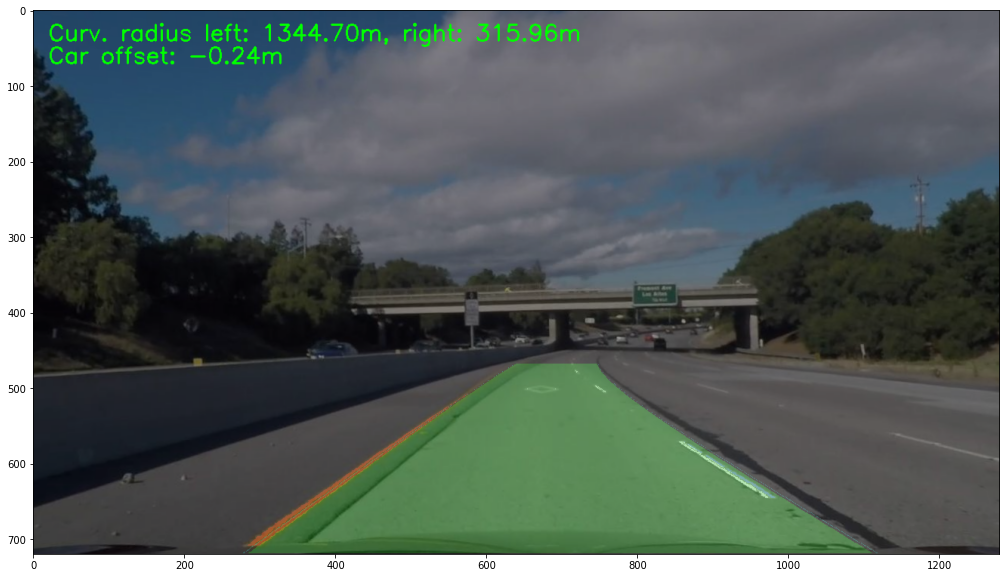

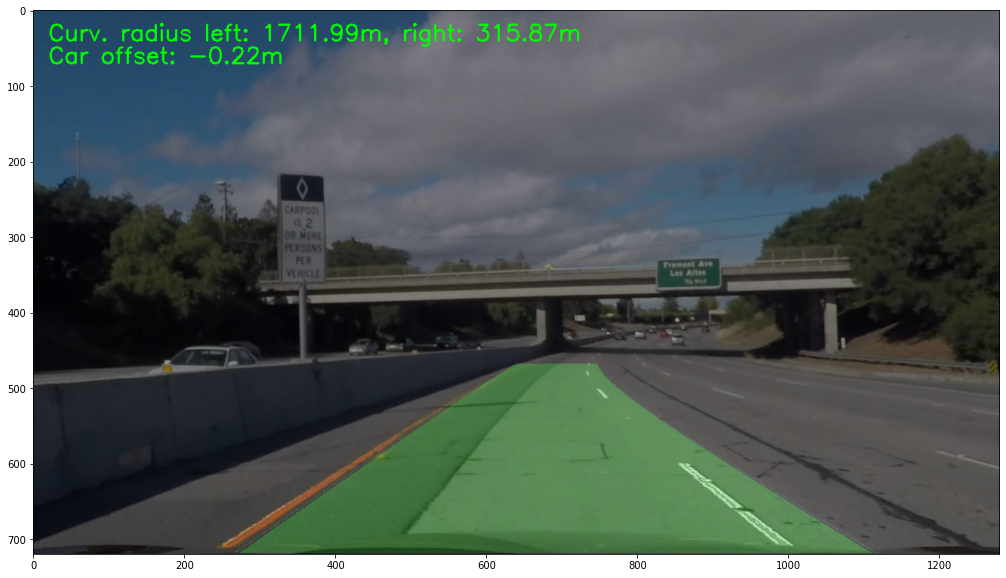

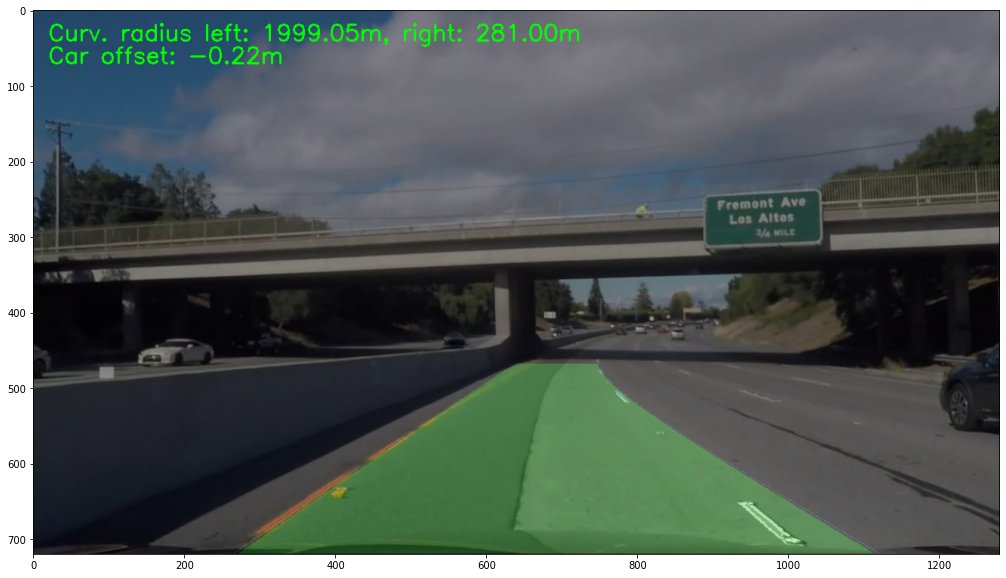

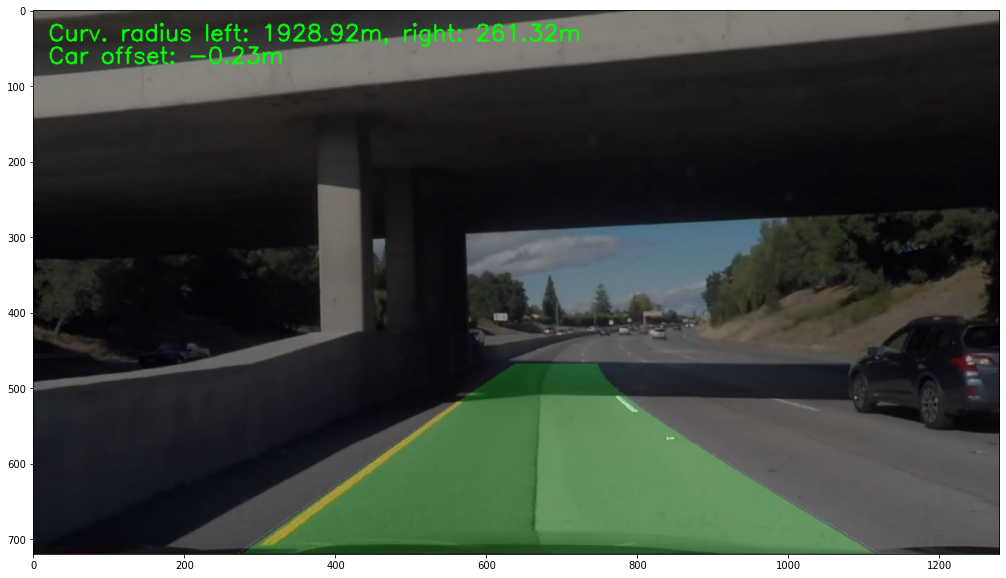

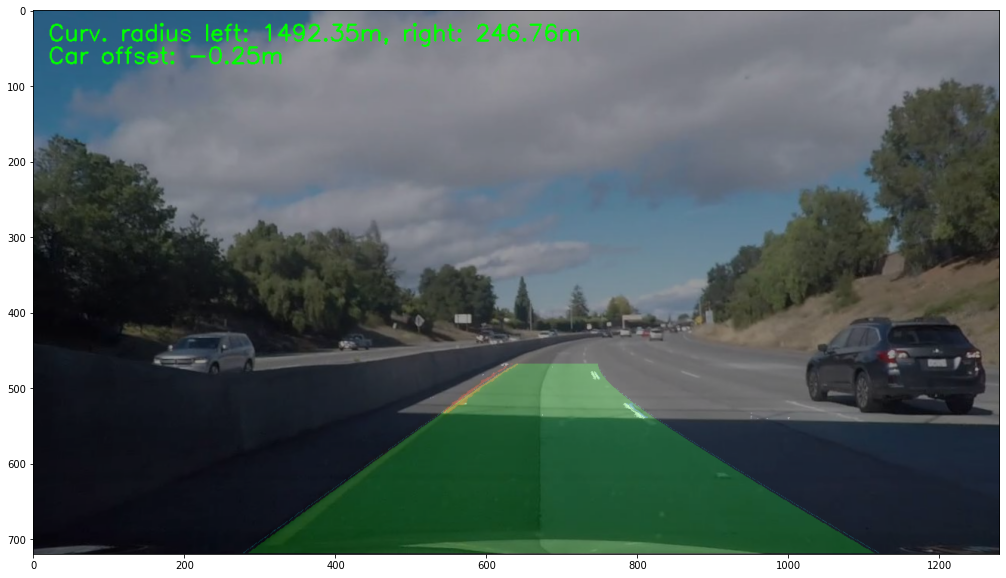

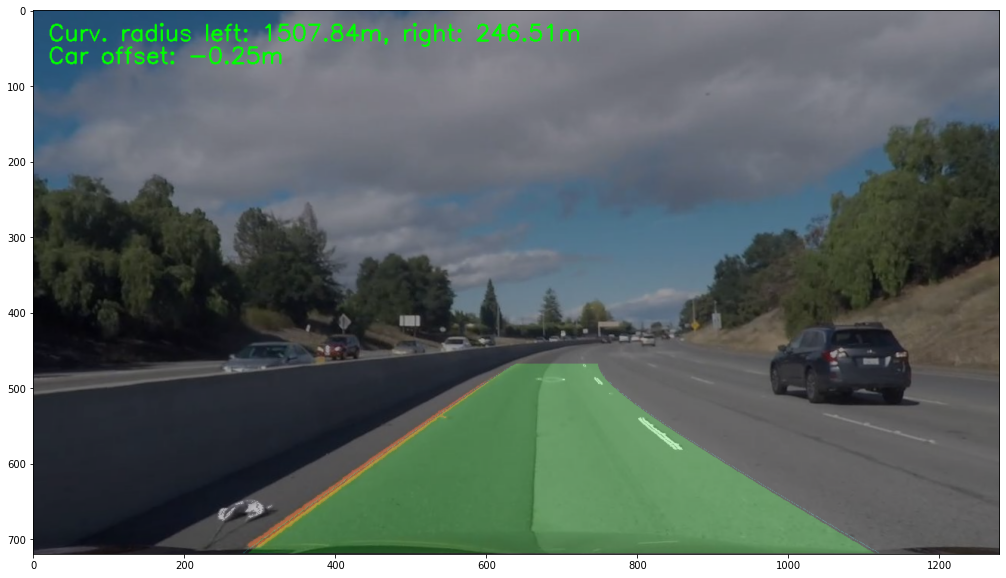

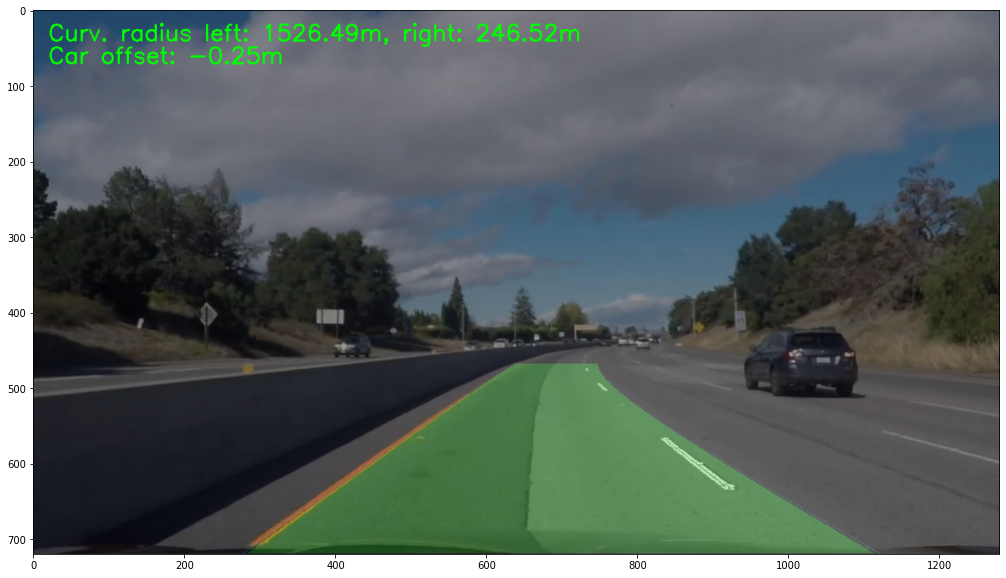

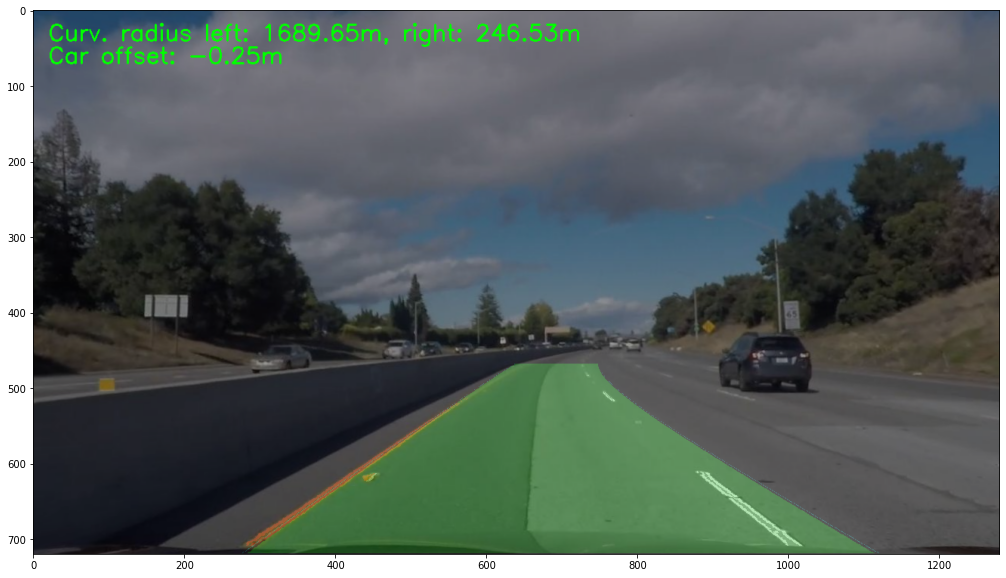

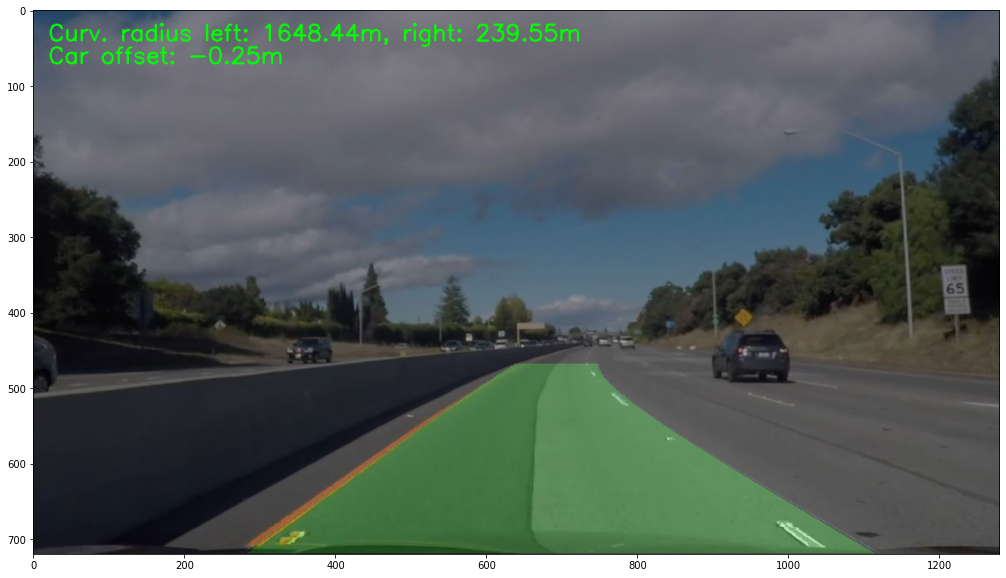

In [28]:

for image_path in test_images[1:]:
    plt.figure(figsize=(18, 10))
    plt.imshow(ld.process_image(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)))
    # visualize(ld.binary_warped, ld.left_fitx, ld.right_fitx, plt)
    plt.tight_layout

## Create/run pipeline on the challenge video

In [29]:
# load video
challenge_video = VideoFileClip('../data/videos/challenge_video.mp4') # .subclip(0,10)
# Extract some frames for testing
# for ts in range(10):
#     challenge_video.save_frame(f"../data/videos/frame_{ts}.jpg", ts)

In [30]:

output_video = '../data/videos/challenge_video_output.mp4'
ld = LaneDetector(calibration_params=calibration_output, warper=Warper( rect_dict2nparray(src),  rect_dict2nparray(dest), pixel_size=pixel_size),
 margin=80, look_back=4)
processed_clip = challenge_video.fl_image(ld.process_image) # expects color image output returned by process image
%time processed_clip.write_videofile(output_video, audio=False)

Moviepy - Building video ../data/videos/challenge_video_output.mp4.
Moviepy - Writing video ../data/videos/challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready ../data/videos/challenge_video_output.mp4
CPU times: user 1min 18s, sys: 12.7 s, total: 1min 31s
Wall time: 24.5 s


In [31]:
ld.processed_images # sanity check on the processed images


486

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

## Radius of curvature (pixel space)

The radius of curvature.
$ R_{curve} = \frac{[[1+ {\frac{d_x}{d_y}}^2]^\frac{3}{2}]}{\frac{d^2x}{d_y}} $

Lane pixels are located (for each side) as second order polynomial $x=f(y)$

$f(y) = A y^2  + B y + C$

$ R_{curve} = \frac{[1 + [2*A*y+B]^2]^\frac{3}{2}}{2*A} $


see lane `lane_detector.convert` implementing the transofmation to meter (space/unit) polynome before applying the (radius of curvature) using the `lane_detector.gen_curvature_calculator`


 ##  Extracting car offset in the lane
 
 Assuming that the camera is mounted somewhere on the vehicle's central (longitudinal) axis, the lane car offset from the center is then obtained by: transforming the center of the original image to warped space, then computing the distance to the lane center convert it in meter. A positive offset value represents a car leaning to the right side, while a negative offset the vehicle leaning to the left side. 